# Курсовая работа "Фреймворк PyTorch для разработки искусственных нейронных сетей"

**1 часть работы: Обучение нейронной сети для распознавания жестов рук**

### Загрузка библиотек

Данные для обучения взяты с https://www.kaggle.com/datasets/gti-upm/leapgestrecog

In [ ]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.4 MB/s eta 0:00:00


In [ ]:
! pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 51.7 MB/s eta 0:00:00


In [ ]:
# Импорт библиотек

import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

from pathlib import Path
from google.colab import drive


In [ ]:
drive.mount('/drive')

Mounted at /drive


### Загрузка данных

In [ ]:
DATA_ROOT = Path('/drive/MyDrive/GB/Pytorch/archive/leapGestRecog/')

In [ ]:
classes_train = os.listdir(DATA_ROOT/"00")
classes_test = os.listdir(DATA_ROOT/"01")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['09_c', '10_down', '03_fist', '05_thumb', '04_fist_moved', '02_l', '08_palm_moved', '06_index', '07_ok', '01_palm']
test Classes - ['06_index', '03_fist', '05_thumb', '04_fist_moved', '02_l', '07_ok', '08_palm_moved', '01_palm']


In [ ]:
for gesture in os.listdir(DATA_ROOT/"00"):
    print(gesture,': ',len(os.listdir(f'{DATA_ROOT/"00"}/{gesture}')))

09_c :  200
10_down :  200
03_fist :  200
05_thumb :  200
04_fist_moved :  200
02_l :  200
08_palm_moved :  200
06_index :  200
07_ok :  200
01_palm :  200


In [ ]:
# функция для переименовывания класса

def digit_to_classname(digit):
    for idx, itm in enumerate(classes_train):
        if idx == digit:
            return itm

### Трансформация данных

In [ ]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Pictures black and white
                         tt.Resize([128, 128]),
                         # Settings for expanding the dataset
                         tt.RandomHorizontalFlip(),           # Random 90 degree rotations
                         tt.RandomRotation(30),               # Random 30 degree rotations
                         tt.ToTensor(),                      # Cast to tensor
                         ])

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])


### Разбивка на тренировочную и тестовую выборку

In [ ]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
    train_ds = ImageFolder(os.path.join(DATA_ROOT, dir), train_tfms)
    test_ds = ImageFolder(os.path.join(DATA_ROOT, dir), test_tfms)
    train_ds_list.append(train_ds)
    test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

Размер датасета

In [ ]:
LEN_DS = len(train_ds)
LEN_DS

3440

In [ ]:
torch.manual_seed(1)

val_split = 0.2
split = int(LEN_DS * val_split)
indices = torch.randperm(LEN_DS)

train_ds = torch.utils.data.Subset(train_ds, indices[split:])
test_ds = torch.utils.data.Subset(test_ds, indices[:split])

len(train_ds), len(test_ds)

(2752, 688)

### Создание даталоудеров

Определим размер батча:

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

Выведем рандомное изображение

torch.Size([3, 128, 128])
tensor(5) 02_l


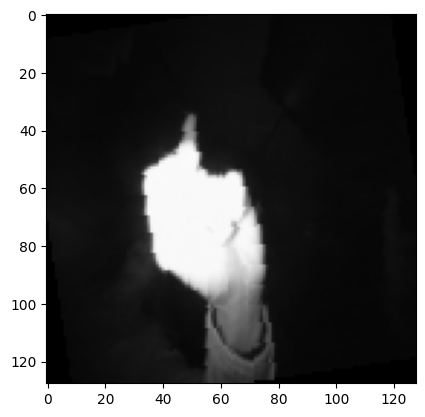

In [ ]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)) #, cmap='gray')
    break

Функция для визуализации батча

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 128, 128])


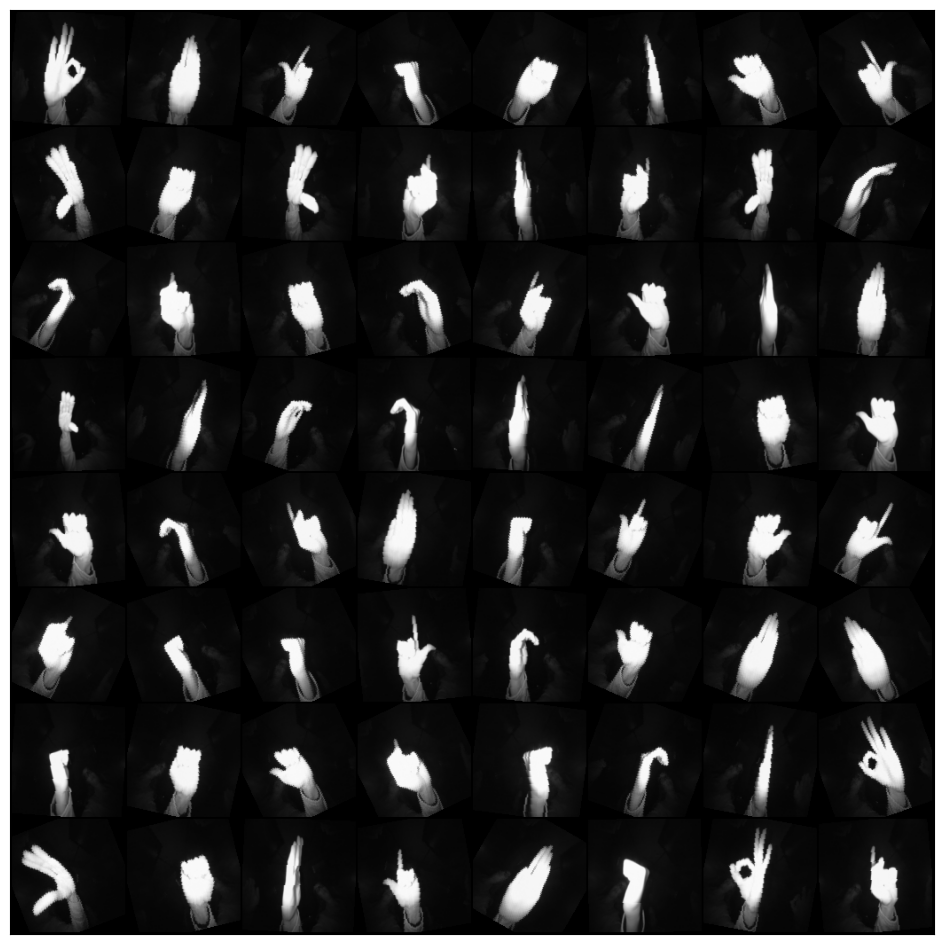

In [ ]:
show_batch(train_dl)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Resnet50 в качестве предобученной сети

In [ ]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

### Заморозка весов

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Перезапись последнего уровня сети


In [ ]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(classes_train))
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

### Инициализация оптимизатора и функции потерь


In [ ]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

### Обучение сети

In [ ]:
epochs = 10

epoch_losses = []

for epoch in range(epochs):

    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dl):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss.append(loss.item())

    test_running_loss = 0
    test_epoch_loss = []
    for batch_idx, (data, labels) in enumerate(test_dl):
        resnet.eval()
        data = data.to(device)
        labels = labels.to(device)

        outputs = resnet(data)
        loss = F.cross_entropy(outputs, labels)

        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())


    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss), 'test loss:', np.mean(test_epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  1.1789544328700665 test loss: 1.2023650841279463
Epoch 2, loss:  0.7504138579202253 test loss: 0.622837941754948
Epoch 3, loss:  0.3858534506587095 test loss: 0.48419700969349255
Epoch 4, loss:  0.2796407082053118 test loss: 0.32375376603820105
Epoch 5, loss:  0.21692241277805593 test loss: 0.2745295614004135
Epoch 6, loss:  0.1637534861301267 test loss: 0.23291880840604956
Epoch 7, loss:  0.15133221811333367 test loss: 0.19893489371646533
Epoch 8, loss:  0.12345446074424787 test loss: 0.1850451569665562
Epoch 9, loss:  0.11578870781285819 test loss: 0.14776681905443018
Epoch 10, loss:  0.10425311569557634 test loss: 0.1530533107844266


Посмотрим на ошибку:

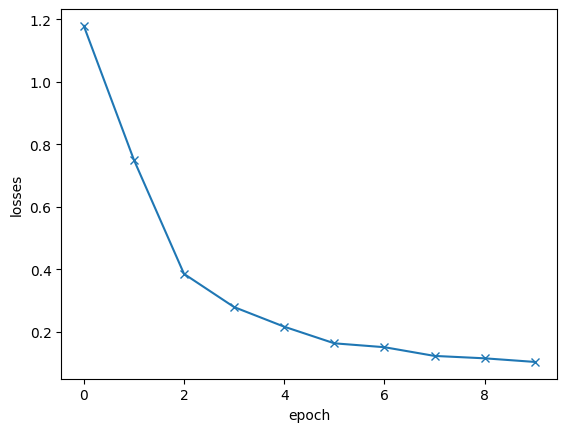

In [ ]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

### Сохранение модели

In [ ]:
torch.save(resnet, './gesture_detection_model.pth')

Теперь загрузим и прогоним ее через тестовый датасет

In [ ]:
net = torch.load('./gesture_detection_model.pth')
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

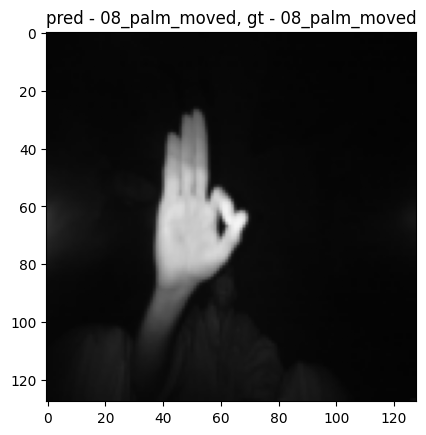

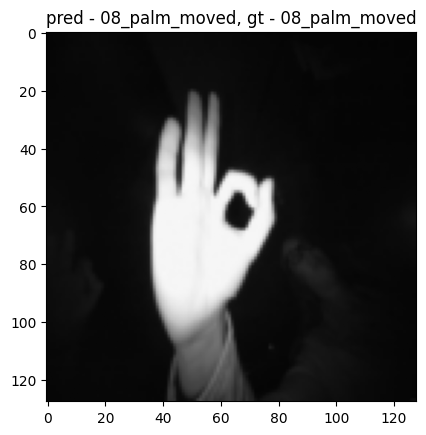

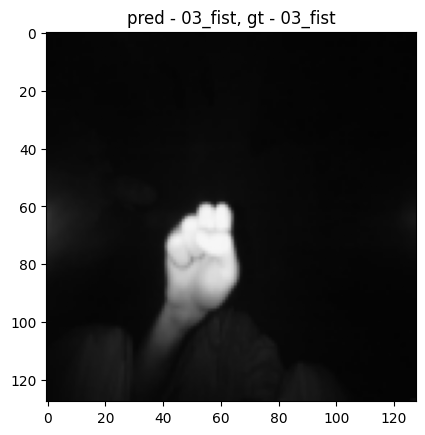

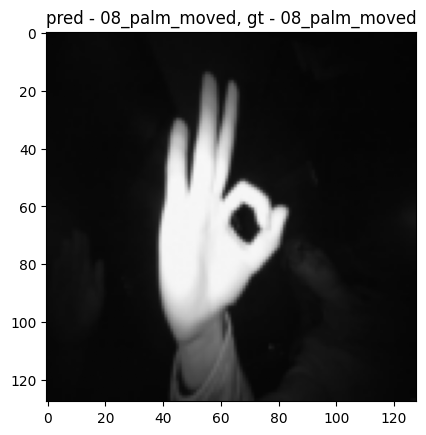

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break